Mitq tutorial: https://mitiq.readthedocs.io/en/stable/examples/ibmq-backends.html

In [2]:
import time, random
import numpy as np
# import pennylane as qml
# from qiskit import Aer, transpile, execute
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import random_clifford, Pauli, Statevector
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, edgeitems=10, linewidth=150, suppress=True)

In [3]:
import qiskit
import itertools
from qiskit import *
from qiskit.quantum_info import Clifford, random_clifford
from qiskit.synthesis import synth_clifford_full
from qiskit.quantum_info import hellinger_fidelity as hf

from utils.pauli_checks import ChecksFinder, add_pauli_checks, add_meas_pauli_checks, add_linear_meas_pauli_checks,  search_for_pauli_list
from utils.pauli_checks import gen_initial_layout, gen_final_layout, complete_postprocess, filter_results

from utils.pauli_checks import convert_to_PCS_circ # new util

from utils.utils import norm_dict, total_counts
# from utils.vqe_utils import evaluation

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import QasmSimulator

from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

#### Backend settings

In [8]:
USE_REAL_HARDWARE = False

In [10]:
from qiskit_ibm_runtime.fake_provider import *
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise
from itertools import combinations

# Make a noise model
# fake_backend = FakeCairo()
# noise_model = noise.NoiseModel.from_backend(fake_backend)

prob_1 = 0.002  # 1-qubit gate
prob_2 = 0.02  # 2-qubit gate

error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'], ['cz'])

In [13]:
if QiskitRuntimeService.saved_accounts() and USE_REAL_HARDWARE:
    service = QiskitRuntimeService()
    backend = service.least_busy(operational=True, simulator=False)
    noise_model = False
else:
    # Simulate the circuit with noise
    # backend = AerSimulator(noise_model=noise_model)
    backend = AerSimulator()

#### Generate circuit

In [16]:
# import supermarq

# num_qubits = 4

# qiskit_test = supermarq.benchmarks.mermin_bell.MerminBell(num_qubits)
# # qiskit_test = supermarq.benchmarks.hamiltonian_simulation.HamiltonianSimulation(num_qubits, total_time=4)
# circuit = qiskit_test.qiskit_circuit()

# # # basis_gates = ["x","sx","rz","cx","rx"]
# transpiled_circ = qiskit.transpile(qiskit_test.qiskit_circuit(), basis_gates = ['x', 'y', 'rz', 's', 'h', 'cx'])
# circuit = transpiled_circ.copy()
# circuit.remove_final_measurements()
# circuit.draw("mpl", fold=-1)

In [18]:
# qreg, creg = qiskit.QuantumRegister(1), qiskit.ClassicalRegister(1)
# # circuit = qiskit.QuantumCircuit(qreg, creg)
# circuit = qiskit.QuantumCircuit(qreg)
# for _ in range(10):
#     circuit.x(qreg)
# # circuit.measure(qreg, creg)
# print(circuit)

# num_qubits = 1

In [20]:
# def hydrogen_trial_circuit(num_qubits):
#     qc = QuantumCircuit(num_qubits)
#     # prepare the Hartree-Fock state
#     qc.x(0)
#     qc.x(1)
    
#     qc.rx(np.pi/2, 0)
#     qc.h(1)
#     qc.h(2)
#     qc.h(3)
    
#     qc.cx(0,1)
#     qc.cx(1,2)
#     qc.cx(2,3)
    
#     # qc.rz(1.0, 3)
    
#     qc.cx(2,3)
#     qc.cx(1,2)
#     qc.cx(0,1)
    
#     qc.rx(-np.pi/2, 0)
#     qc.h(1)
#     qc.h(2)
#     qc.h(3)
    
#     return qc

# num_qubits = 4
# circuit = hydrogen_trial_circuit(num_qubits)
# # circuit.measure_all()
# print(circuit)

In [22]:
def ghz_mirror_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)

    # p = 4
    p = 1
    for _ in range(p):
        qc.h(0)
        for i in range(1, num_qubits):
            qc.cx(0, i)
        for i in range(num_qubits-1, 0, -1):
            qc.cx(0, i)
        qc.h(0)
        # for i in range(num_qubits):
        #     qc.x(i)
        #     qc.x(i)
        #     qc.x(i)
        #     qc.x(i)
    
    # qc.h(0)
    # for i in range(1, num_qubits):
    #     qc.cx(0, i)
    # for i in range(num_qubits-1, 0, -1):
    #     qc.cx(0, i)
    # qc.h(0)

    # for i in range(num_qubits):
    #     qc.x(i)
    #     qc.x(i)
    #     qc.x(i)
    #     qc.x(i)

    # for i in range(num_qubits):
    #     qc.x(i)
    #     qc.x(i)
    #     qc.x(i)
    #     qc.x(i)

    return qc



num_qubits = 4
circuit = ghz_mirror_circuit(num_qubits)
print(circuit)

     ┌───┐                              ┌───┐
q_0: ┤ H ├──■────■────■────■────■────■──┤ H ├
     └───┘┌─┴─┐  │    │    │    │  ┌─┴─┐└───┘
q_1: ─────┤ X ├──┼────┼────┼────┼──┤ X ├─────
          └───┘┌─┴─┐  │    │  ┌─┴─┐└───┘     
q_2: ──────────┤ X ├──┼────┼──┤ X ├──────────
               └───┘┌─┴─┐┌─┴─┐└───┘          
q_3: ───────────────┤ X ├┤ X ├───────────────
                    └───┘└───┘               


#### Set observable(s)

In [38]:
pauli_string = 'Z'*num_qubits
# pauli_string = 'X'*num_qubits
pauli_string = 'IIIZ'

#### Ideal result

In [41]:
psi = Statevector(circuit)
operator = Pauli(pauli_string)
expect = np.array(psi).T.conj() @ operator.to_matrix() @ np.array(psi)
print(expect)

(0.9999999999999996+0j)


#### Run ZNE

In [44]:
def apply_measurement_basis(circuit, pauli_string):
    """Modify the circuit to measure in the basis specified by the Pauli string."""
    for i, pauli in enumerate(pauli_string):
        if pauli == 'X':
            circuit.h(i)
        elif pauli == 'Y':
            circuit.sdg(i)
            circuit.h(i)

def compute_expectation_value(counts, pauli_string):
    """Compute expectation value of a Pauli string observable from measurement counts."""
    total_shots = sum(counts.values())
    expectation = 0

    for bitstring, count in counts.items():
        # Reverse bitstring if needed to match Qiskit's little-endian convention
        bitstring = bitstring[::-1]
        value = 1

        for i, pauli in enumerate(pauli_string):
            if pauli == 'I':
                continue
            elif pauli == 'Z' or pauli == 'X' or pauli == 'Y':
                # X and Y are already rotated to Z basis, so interpret as Z
                value *= 1 if bitstring[i] == '0' else -1
            else:
                raise ValueError(f"Invalid Pauli operator: {pauli}")

        expectation += value * count

    return expectation / total_shots


def ibmq_executor(circuit: QuantumCircuit, shots: int = 10_000):
    """Returns the expectation value of the Pauli string observable.

    Args:
        circuit: Circuit to run.
        pauli_string: String representing the Pauli operators to be measured (e.g., 'XYZI').
        shots: Number of times to execute the circuit.
        backend: Simulator or real quantum device to execute the circuit.
    """
    # Modify the circuit to measure the required Pauli observables
    measurement_circuit = circuit.copy()
    measurement_circuit.barrier()
    apply_measurement_basis(measurement_circuit, pauli_string)
    measurement_circuit.measure_all()
    # print(measurement_circuit)

    # Transpile for the backend
    exec_circuit = transpile(
        measurement_circuit,
        backend=backend,
        optimization_level=0 # Preserve gate structure for simulation accuracy.
    )

    # print("transpiled circuit")
    # print(exec_circuit)

    # Run the circuit
    job = backend.run(exec_circuit, shots=shots)
    counts = job.result().get_counts()

    # Compute the expectation value based on counts
    # expectation_value = sum((-1 if (bin(int(state, 16)).count('1') % 2) else 1) * count for state, count in counts.items()) / shots
    expectation_value = compute_expectation_value(counts, pauli_string)
    return expectation_value
    

In [46]:
unmitigated = ibmq_executor(circuit)
mitigated = zne.execute_with_zne(circuit, ibmq_executor)
print(f"Unmitigated result {unmitigated:.3f}")
print(f"Mitigated result {mitigated:.3f}")

Unmitigated result 1.000
Mitigated result 1.000


#### Run PCE

In [49]:
# num_checks = 2*num_qubits
num_checks = num_qubits

circs_list = []
signs_list = []
for check_id in range(1, num_checks + 1):
    print(check_id)
    sign, circ = convert_to_PCS_circ(circuit, num_qubits, check_id)
    circs_list.append(circ)
    signs_list.append(sign)

print(signs_list)

1
Found check 1: +1IIIX, +1IIIX
Required number of checks found.
p1_list =  [['+1IIIX', '+1IIIX']]
2
Found check 1: +1IIIX, +1IIIX
Found check 2: +1IIIZ, +1IIIZ
Required number of checks found.
p1_list =  [['+1IIIX', '+1IIIX'], ['+1IIIZ', '+1IIIZ']]
3
Found check 1: +1IIIX, +1IIIX
Found check 2: +1IIIZ, +1IIIZ
Found check 3: +1IIXI, +1IIXI
Required number of checks found.
p1_list =  [['+1IIIX', '+1IIIX'], ['+1IIIZ', '+1IIIZ'], ['+1IIXI', '+1IIXI']]
4
Found check 1: +1IIIX, +1IIIX
Found check 2: +1IIIZ, +1IIIZ
Found check 3: +1IIXI, +1IIXI
Found check 4: +1IIZI, +1IIZI
Required number of checks found.
p1_list =  [['+1IIIX', '+1IIIX'], ['+1IIIZ', '+1IIIZ'], ['+1IIXI', '+1IIXI'], ['+1IIZI', '+1IIZI']]
[['+1'], ['+1', '+1'], ['+1', '+1', '+1'], ['+1', '+1', '+1', '+1']]


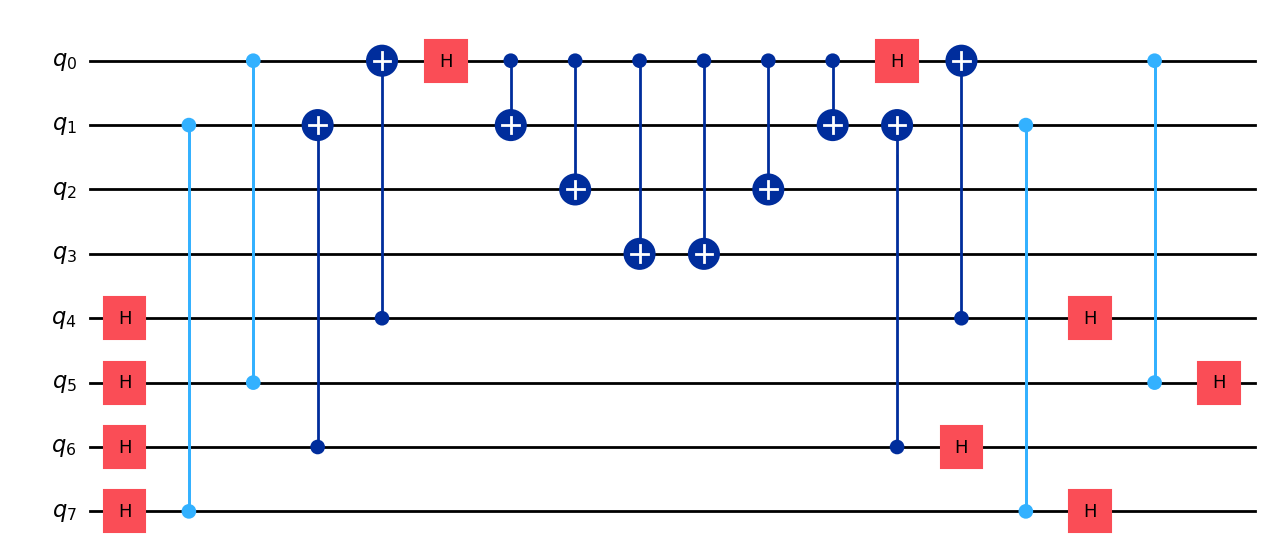

In [51]:
circs_list[-1].draw("mpl", fold=-1)

#### Compute Expectation

In [54]:
def filter_counts(counts, num_checks):
    filtered_counts = {}
    for state, count in counts.items():
        if all(bit == '0' for bit in state[:num_checks]):
            remaining_state = state[num_checks:]
            if remaining_state in filtered_counts:
                filtered_counts[remaining_state] += count
            else:
                filtered_counts[remaining_state] = count

    return filtered_counts

def ibmq_executor_pcs(circuit: QuantumCircuit, num_qubits, shots: int = 10_000):
    """Returns the expectation value of the Pauli string observable.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit.
        backend: Simulator or real quantum device to execute the circuit.
    """
    # pauli_string = "Z"*8
    # Modify the circuit to measure the required Pauli observables
    measurement_circuit = circuit.copy()
    apply_measurement_basis(measurement_circuit, pauli_string)
    measurement_circuit.measure_all()
    # print(measurement_circuit)

    # Transpile for the backend
    exec_circuit = transpile(
        measurement_circuit,
        backend=backend,
        optimization_level=0,  # Preserve gate structure for simulation accuracy.
    )

    # print("transpiled circuit")
    # print(exec_circuit)

    # Run the circuit
    job = backend.run(exec_circuit, shots=shots)
    # print(job.result().quasi_dists)

    
    counts = job.result().get_counts()
    # print("counts: ", counts)
    # print()

    # Filter counts based on check data
    total_qubits = circuit.num_qubits
    num_checks = total_qubits - num_qubits
    filtered_counts = filter_counts(counts, num_checks)
    # print("filtered_counts: ", filtered_counts)

    # Compute the expectation value based on filtered counts
    expectation_value = compute_expectation_value(filtered_counts, pauli_string)
    
    # expectation_value = 0
    # total_filtered_shots = sum(filtered_counts.values())
    # for state, count in filtered_counts.items():
    #     parity = -1 if (bin(int(state, 2)).count('1') % 2) else 1
    #     expectation_value += parity * count

    # # Normalize by the total number of shots that contributed
    # if total_filtered_shots > 0:
    #     expectation_value /= total_filtered_shots
    # else:
    #     expectation_value = 0  # No counts met the filter criteria

    return expectation_value

In [56]:
# ibmq_executor_pcs(circ, num_qubits)

In [58]:
# ibmq_executor_pcs(circs_list[0], num_qubits)

#### Run PCS for each # of checks

In [61]:
expectation_values = []
for i in range(num_checks):
    print(i)
    pcs_circ = circs_list[i]
    expectation_value = ibmq_executor_pcs(pcs_circ, num_qubits = num_qubits)
    expectation_values.append(expectation_value)

0
1
2
3


In [63]:
print(expectation_values)

[1.0, 1.0, 1.0, 1.0]


#### Extrapolate checks

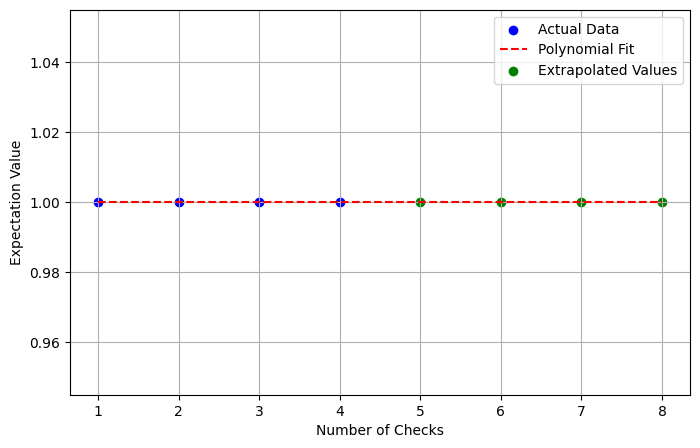

Extrapolated expectation value at check number 5: 1.0000
Extrapolated expectation value at check number 6: 1.0000
Extrapolated expectation value at check number 7: 1.0000
Extrapolated expectation value at check number 8: 1.0000


In [66]:
import numpy as np
import matplotlib.pyplot as plt

num_checks_to_fit = num_checks
check_numbers = range(1, num_checks_to_fit+1)

# extrapolation_layers = range(num_checks_to_fit+1, 2*num_checks_to_fit+1)
extrapolation_layers = range(num_checks_to_fit+1, 2*num_qubits+1) # extraplate to 2n

# Fit a polynomial of degree 1 (linear fit) to the check_numbers and expectation_values
polynomial_coefficients = np.polyfit(check_numbers, expectation_values[:num_checks_to_fit], 1)
polynomial = np.poly1d(polynomial_coefficients)

extrapolated_values = polynomial(list(extrapolation_layers))

x_values = np.linspace(min(check_numbers), max(extrapolation_layers), 400)
y_values = polynomial(x_values)

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(check_numbers, expectation_values[:num_checks_to_fit], color='blue', label='Actual Data')
plt.plot(x_values, y_values, 'r--', label='Polynomial Fit')
plt.scatter(list(extrapolation_layers), extrapolated_values, color='green', label='Extrapolated Values')
plt.xlabel('Number of Checks')
plt.ylabel('Expectation Value')
plt.legend()
plt.grid(True)
plt.show()

# Print out the extrapolated values
for layer, value in zip(extrapolation_layers, extrapolated_values):
    print(f"Extrapolated expectation value at check number {layer}: {value:.4f}")


In [68]:
print(f"ZNE result {mitigated:.3f}")

ZNE result 1.000


# Tests